In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [6]:
# Image size & batch size
img_height, img_width = 224, 224   # MobileNetV2 default
batch_size = 32

# Load train, validation, and test datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    "Dog_Breed_Classification/train",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "Dog_Breed_Classification/val",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "Dog_Breed_Classification/test",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False   # Don’t shuffle test set
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)


Found 6391 files belonging to 93 classes.
Found 762 files belonging to 93 classes.
Found 887 files belonging to 93 classes.
Classes: ['afghan_hound', 'african_hunting_dog', 'airedale', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'brabancon_griffon', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'entlebucher', 'flat-coated_retriever', 'german_shepherd', 'german_short-haired_pointer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'irish_water_spaniel', 'irish_wolfhound', 'japanese_spaniel', 'keeshond', 'kerry_blue_terrier', 'komondor', 'kuvasz', 'labrador_ret

In [7]:
# Normalize pixel values
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Performance boost
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [8]:
base_model = MobileNetV2(weights="imagenet", include_top=False,
                         input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze base layers

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)


Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 279s 1s/step - accuracy: 0.3100 - loss: 2.9002 - val_accuracy: 0.6877 - val_loss: 1.1788
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.5896 - loss: 1.5042 - val_accuracy: 0.7362 - val_loss: 0.8874
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.6514 - loss: 1.2399 - val_accuracy: 0.7625 - val_loss: 0.7639
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.6727 - loss: 1.1308 - val_accuracy: 0.7651 - val_loss: 0.7682
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.7033 - loss: 0.9923 - val_accuracy: 0.7756 - val_loss: 0.7232
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.7260 - loss: 0.9402 - val_accuracy: 0.7664 - val_loss: 0.7066
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.7451 - loss: 0.8769 - val_accuracy: 0.7769 - val_loss: 0.7097
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.7482 - loss: 0.8422 - val_accu

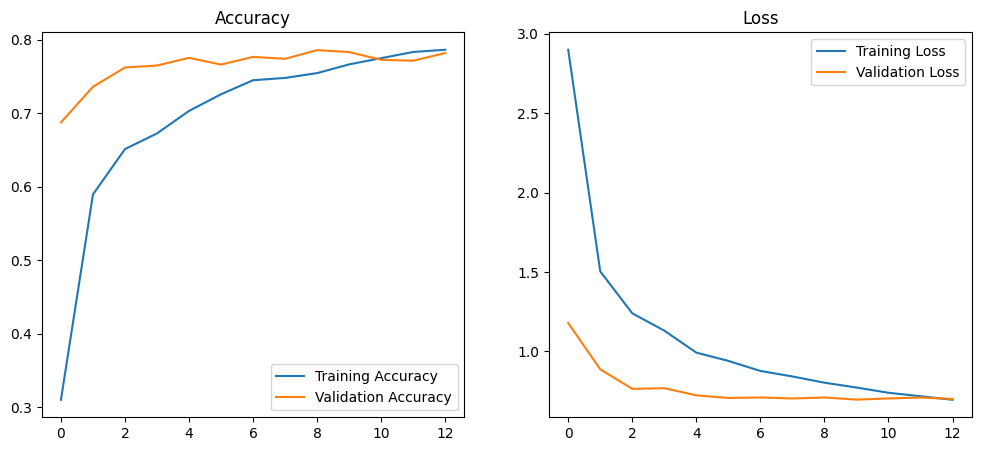

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.show()


In [11]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test accuracy: {test_acc:.2f}")


28/28 ━━━━━━━━━━━━━━━━━━━━ 30s 989ms/step - accuracy: 0.8106 - loss: 0.6020
✅ Test accuracy: 0.81


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

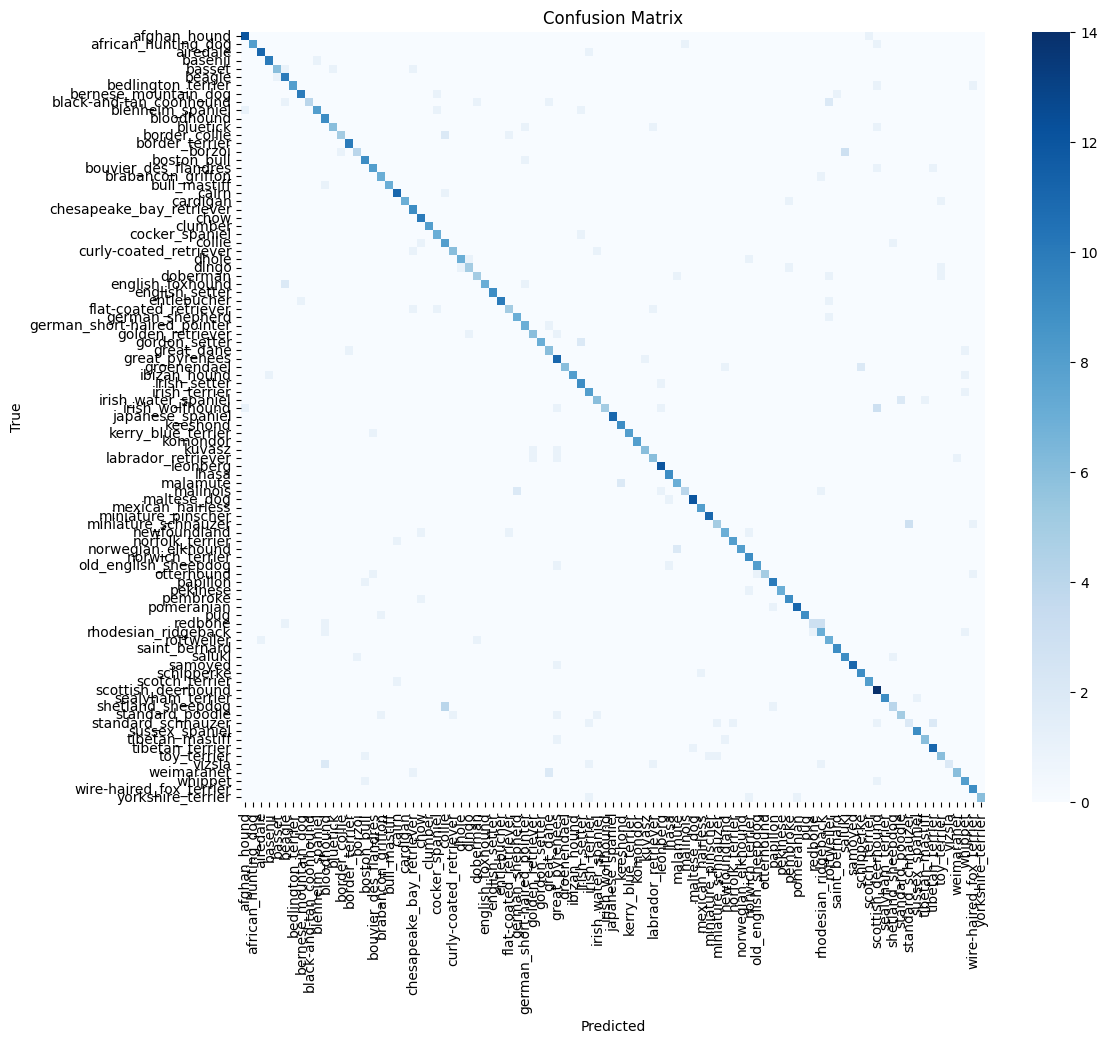

In [12]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [17]:
img_path = "Rottweiler.jpg"  # <-- change this to a real test image path
img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) / 255.0  # normalize

predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions[0])]
confidence = np.max(predictions[0]) * 100

print(f"Prediction: {predicted_class} ({confidence:.2f}% confidence)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Prediction: rottweiler (96.97% confidence)


In [18]:
model.save('Image_classify.keras')